# Day 18: Snailfish


In [1]:
import pytest

## Grammar

Pairs are written as `[x,y]`, where `x` and `y` are the elements within the pair. Here are some example snailfish numbers, one snailfish number per line:

```
[1,2]
[[1,2],3]
[9,[8,7]]
[[1,9],[8,5]]
[[[[1,2],[3,4]],[[5,6],[7,8]]],9]
[[[9,[3,8]],[[0,9],6]],[[[3,7],[4,9]],3]]
[[[[1,3],[5,3]],[[1,3],[8,7]]],[[[4,9],[6,9]],[[8,2],[7,3]]]]
```

$$ node \rightarrow \textbf{[} \space node \space \textbf{,} \space node \space \textbf{]} \space | \space  terminal $$

$$ terminal \rightarrow \textbf{0} | \textbf{1} | \textbf{2} | \textbf{3} | \textbf{4} | \textbf{5} | \textbf{6} | \textbf{7} | \textbf{8} | \textbf{9} $$

![node](node.svg)

![terminal](terminal.svg)

In [2]:
def load_input(filename):
    with open(filename) as fr:
        for line in fr.readlines():
            yield line.strip()

In [3]:
class Terminal():

    def __init__(self, c, level=0):
        self.value = int(c)
        self.parent = None
        
    def __str__(self):
        return str(self.value)
    
    def __repr__(self):
        return f"Terminal({self.value})"
        
    def is_terminal(self):
        return True
    

class Node:
    
    def __init__(self, left, right):
        self.parent = None
        self.left = left
        self.left.parent = self 
        self.right = right
        self.right.parent = self 
        
    def __str__(self):
        return f'[{self.left},{self.right}]'

    def __repr__(self):
        return f"Node({self.left!r}, {self.right!r})"

    def is_terminal(self):
        return False
        
    
    
assert Terminal('3').value == 3
node = Node(Terminal('2'), Terminal('5'))
assert node.left.value == 2
assert node.right.value == 5

## Parser

In [4]:
def consume(stream, expected):
    next_symbol = next(stream)
    if next_symbol != expected:
        raise ValueError(f"Expected {expected}, found {next_symbol}")
        
stream = iter('abc')
assert consume(stream, 'a') is None
with pytest.raises(ValueError):
    consume(stream, 'a')

In [5]:
def parser(stream):
    c = next(stream)
    if c == "[":
        left = parser(stream)
        consume(stream, ",")
        right = parser(stream)
        consume(stream, "]")
        result = Node(left, right)
    else:
        result = Terminal(c)
    return result

In [6]:
n = parser(iter('[3,5]'))

In [7]:
print(n, n.parent, n.left.parent, n.right.parent)

[3,5] None [3,5] [3,5]


In [8]:
n = parser(iter('[[1,2],5]'))

In [9]:
print(n, n.parent,)
print(n.left, n.left.parent)
print(n.right, n.right.parent)

[[1,2],5] None
[1,2] [[1,2],5]
5 [[1,2],5]


In [10]:
n = parser(iter('[[[[1,3],[5,3]],[[1,3],[8,7]]],[[[4,9],[6,9]],[[8,2],[7,3]]]]'))
print(n)

[[[[1,3],[5,3]],[[1,3],[8,7]]],[[[4,9],[6,9]],[[8,2],[7,3]]]]


In [11]:
import string
import itertools

class Nominator:
    
    def __init__(self, size=2):
        self.generator = itertools.cycle(
            itertools.product(
                *itertools.tee(iter(string.ascii_lowercase), size)
            )
        )
        
    def __call__(self):
        letters = list(next(self.generator))
        return ''.join(letters)
    
    
new_name = Nominator()
assert new_name() == 'aa'
assert new_name() == 'ab'

In [12]:
def iter_tree(node):
    if node.is_terminal():
        yield node
    else:
        yield from iter_tree(node.left)
        yield node
        yield from iter_tree(node.right)

In [13]:
def level(node):
    result = 0
    while node.parent is not None:
        result += 1
        node = node.parent
    return result

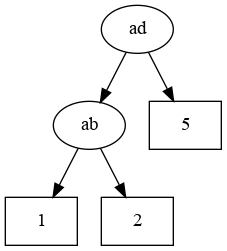

In [14]:
import pydot
from collections import defaultdict
from IPython.display import Image, display

def view_nodes(root):
    buff = [
        'digraph G {',
    ]
    new_name = Nominator()
    names = defaultdict(new_name)
    for n in iter_tree(root):
        if n.is_terminal():
            names[n] = '_'.join([new_name(), str(n.value)])
            color = 'black' if n.value < 10 else 'red'
            buff.append(f'  {names[n]}[shape=box,color={color},label="{n.value}"];')
        else:
            names[n] = new_name()
            color = 'black' if level(n) < 4 else 'green'
            buff.append(f'  {names[n]}[color={color}];')
    for n in iter_tree(root):
        if not n.is_terminal():
            parent_name = names[n]
            left_name = names[n.left]
            buff.append(f' {parent_name} -> {left_name};')
            right_name = names[n.right]
            buff.append(f' {parent_name} -> {right_name};')    
    buff.append("}")
    graph = pydot.graph_from_dot_data('\n'.join(buff))[0]                            
    return graph.create_png()

n = parser(iter('[[1,2],5]'))
display(Image(view_nodes(n)))

This snailfish homework is about addition. To add two snailfish numbers, form a pair from the left and right parameters of the addition operator. For example, [1,2] + [[3,4],5] becomes [[1,2],[[3,4],5]].

In [15]:
def add_nodes_test(n1, n2):
    return Node(n1, n2)

In [16]:
n1 = parser(iter('[1,2]'))
n2 = parser(iter('[[3,4],5]'))
n3 = add_nodes_test(n1, n2)
assert str(n3) == '[[1,2],[[3,4],5]]'
assert n1.parent == n3
assert n2.parent == n3
assert n3.parent is None

There's only one problem: snailfish numbers **must always be reduced**, and the process of adding two snailfish numbers can result in snailfish numbers that need to be reduced.

To reduce a snailfish number, you must repeatedly do the first action in this list that applies to the snailfish number:

- If any pair is nested inside four pairs, the leftmost such pair explodes.
If any regular number is 10 or greater, the leftmost such regular number splits.
Once no action in the above list applies, the snailfish number is reduced.

- During reduction, at most one action applies, after which the process returns to the top of the list of actions. For example, if split produces a pair that meets the explode criteria, that pair explodes before other splits occur.

In [17]:
n = parser(iter('[[1,2],[[3,4],5]]'))
print (n, level(n))
print (n.left, level(n.left))
print (n.right, level(n.right))
print (n.left.left, level(n.left.left))

[[1,2],[[3,4],5]] 0
[1,2] 1
[[3,4],5] 1
1 2


To explode a pair, the pair's left value is added to the first regular number to the left of the exploding pair (if any), and the pair's right value is added to the first regular number to the right of the exploding pair (if any). Exploding pairs will always consist of two regular numbers. Then, the entire exploding pair is replaced with the regular number 0.

In [18]:
def explode_left(node, tron=False):
    if tron:
        print(f"Explode left node: {node!r} level: {level(node)}")
    assert not node.is_terminal()
    value = node.left.value
    if tron:
        print(f" - value to distribute {value}")
    target = node
    while target:
        if target.parent and target.parent.left is not target:
            target = target.parent.left
            break
        target = target.parent
    if target:
        while not target.is_terminal():
            target = target.right
        if tron:
            print(f"   - node is {target} {target!r}")
            print(f"   - old value is {target.value}")
        target.value += value
        if tron:
            print(f"   - new value is {target.value}")
        return
    if tron:
        print(f"  - Value {value} vanished")


def explode_right(node, tron=False):
    if tron:
        print(f"Explode right node: {node!r} level: {level(node)}")
    assert not node.is_terminal()
    value = node.right.value
    if tron:
        print(f" - value to distribute {value}")
    target = node
    while target:
        if target.parent and target.parent.right is not target:
            target = target.parent.right
            break  
        target = target.parent
    if target:
        while not target.is_terminal():
            target = target.left
        if tron:
            print(f"   - node is {target} {target!r}")
            print(f"   - old value is {target.value}")
        target.value += value
        if tron:
            print(f"   - new value is {target.value}")
        return
    
    if tron:
        print(f"  - Value {value} vanished (Right)")
        
        
def explode(node, tron=False):
    base = node.parent
    explode_left(node, tron=tron)
    explode_right(node, tron=tron)    
    new_node = Terminal("0")
    if base.right is node:
        base.right = new_node
    else:
        base.left = new_node
    new_node.parent = base
    

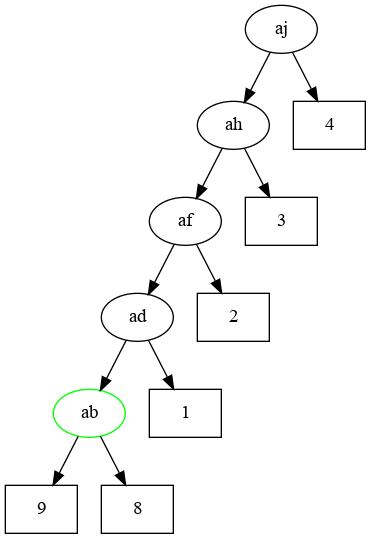

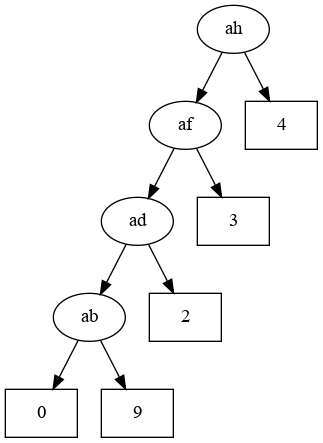

In [19]:
n = parser(iter('[[[[[9,8],1],2],3],4]'))
display(Image(view_nodes(n)))
explode(n.left.left.left.left)
display(Image(view_nodes(n)))
assert str(n) == '[[[[0,9],2],3],4]'

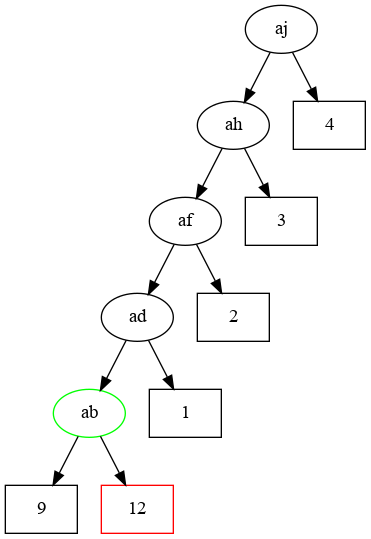

In [20]:
n = parser(iter('[[[[[9,8],1],2],3],4]'))
n.left.left.left.left.right.value += 4
img = Image(view_nodes(n))
img

In [21]:
n = parser(iter('[7,[6,[5,[4,[3,2]]]]]'))
explode(n.right.right.right.right)
assert str(n) == '[7,[6,[5,[7,0]]]]'

`[[6,[5,[4,[3,2]]]],1]` becomes `[[6,[5,[7,0]]],3]`.

In [22]:
n = parser(iter('[[6,[5,[4,[3,2]]]],1]'))
# display(Image(view_nodes(n)))
explode(n.left.right.right.right)
# display(Image(view_nodes(n)))
assert str(n) == '[[6,[5,[7,0]]],3]'

`[[3,[2,[1,[7,3]]]],[6,[5,[4,[3,2]]]]]` becomes `[[3,[2,[8,0]]],[9,[5,[4,[3,2]]]]]` (the pair `[3,2]` is unaffected because the pair `[7,3]` is further to the left; `[3,2]` would explode on the next action).

In [23]:
n = parser(iter('[[3,[2,[1,[7,3]]]],[6,[5,[4,[3,2]]]]]'))
# display(Image(view_nodes(n)))
explode(n.left.right.right.right)
# display(Image(view_nodes(n)))
assert str(n) == '[[3,[2,[8,0]]],[9,[5,[4,[3,2]]]]]'

`[[3,[2,[8,0]]],[9,[5,[4,[3,2]]]]]` becomes `[[3,[2,[8,0]]],[9,[5,[7,0]]]]`.

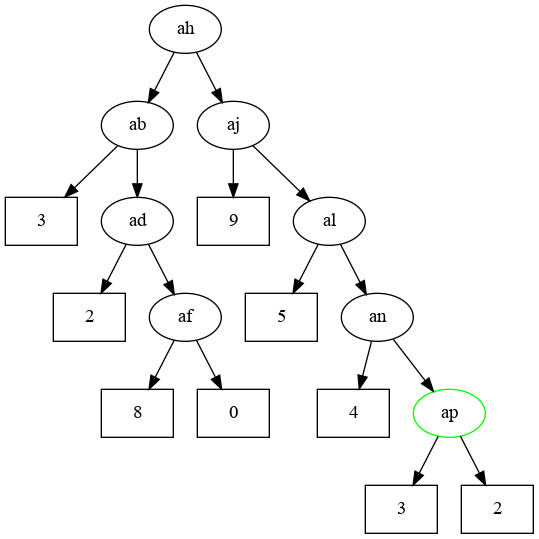

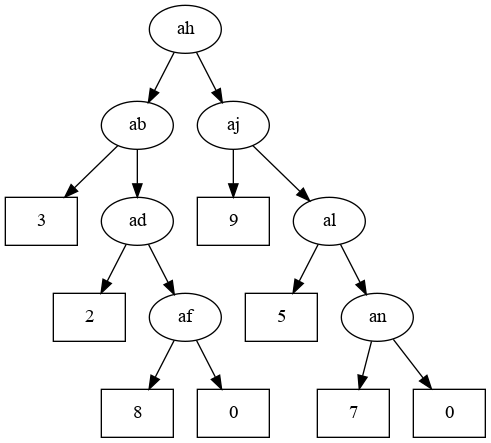

In [24]:
n = parser(iter('[[3,[2,[8,0]]],[9,[5,[4,[3,2]]]]]'))
display(Image(view_nodes(n)))
explode(n.right.right.right.right)
display(Image(view_nodes(n)))
assert str(n) == '[[3,[2,[8,0]]],[9,[5,[7,0]]]]'

To split a regular number, replace it with a pair; the left element of the pair should be the regular number divided by two and rounded down, while the right element of the pair should be the regular number divided by two and rounded up. For example, 10 becomes [5,5], 11 becomes [5,6], 12 becomes [6,6], and so on.

In [25]:
import math

def split_node(node, tron=False):
    grandparent = node.parent
    assert node.is_terminal()
    assert node.value > 9
    low_val = math.floor(node.value / 2)
    high_val = math.ceil(node.value / 2)
    left_node = Terminal(str(low_val))
    right_node = Terminal(str(high_val))
    new_node = Node(left_node, right_node)
    left_node.parent = new_node
    right_node.parent = new_node
    new_node.parent = grandparent
    if grandparent:
        if grandparent.right is node:
            grandparent.right = new_node
        else:
            grandparent.left = new_node
    return new_node

t = Terminal('9')
p = Node(t, Terminal('7'))
t.value += 2
n = split_node(t)
assert str(n) == '[5,6]'
assert n.left.parent is n
assert n.right.parent is n
assert str(p) == '[[5,6],7]'

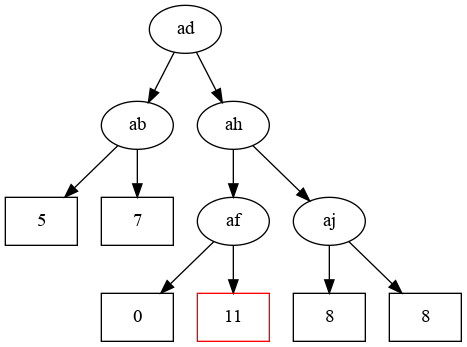

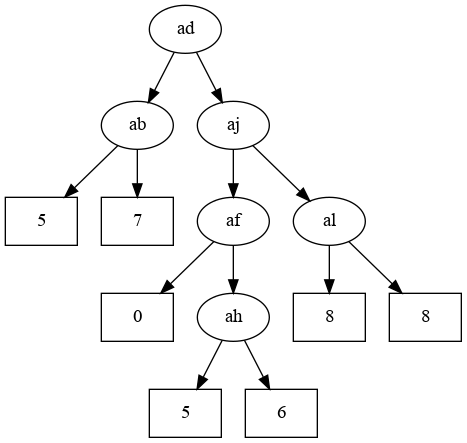

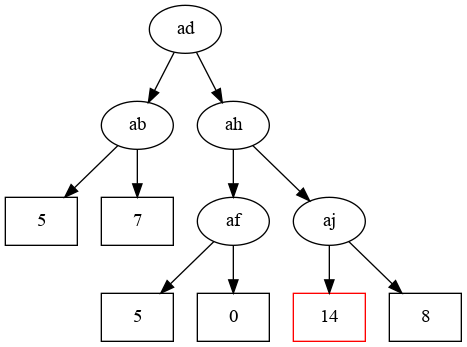

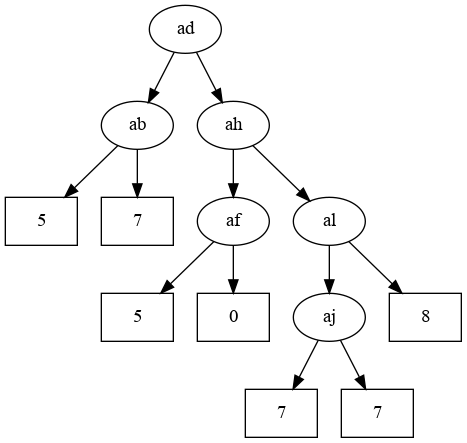

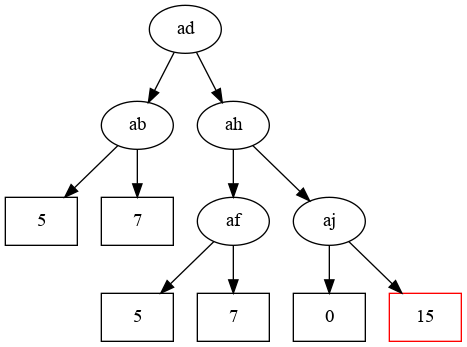

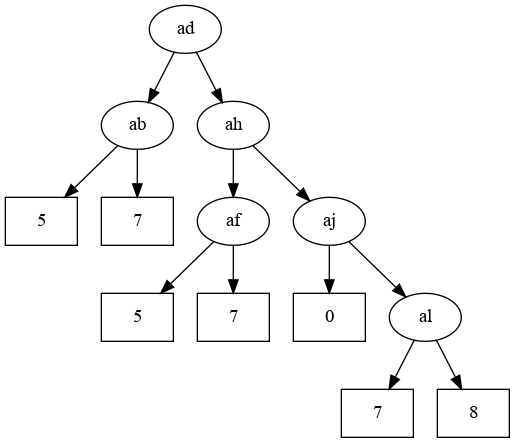

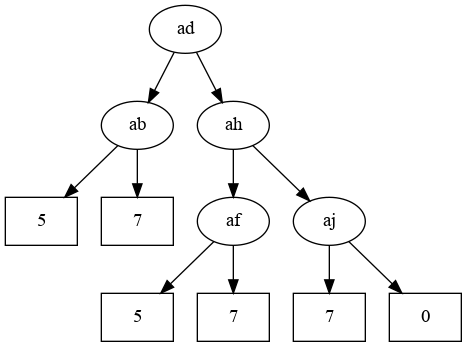

In [26]:
n = parser(iter('[[5,7],[[0,9],[8,8]]]'))
n.right.left.right.value += 2
display(Image(view_nodes(n)))
split_node(n.right.left.right)
display(Image(view_nodes(n)))
explode(n.right.left.right)
display(Image(view_nodes(n)))
split_node(n.right.right.left)
display(Image(view_nodes(n)))
explode(n.right.right.left)
display(Image(view_nodes(n)))
split_node(n.right.right.right)
display(Image(view_nodes(n)))
explode(n.right.right.right)
display(Image(view_nodes(n)))


To reduce a snailfish number, you must repeatedly do the first action in this list that applies to the snailfish number:

- If any pair is nested inside four pairs, the leftmost such pair explodes.

- If any regular number is 10 or greater, the leftmost such regular number splits.

In [27]:
def reduce_node(node, tron=False):
    if tron:
        print(f'<<< {node} >>>')
    for n in iter_tree(node):
        if (not n.is_terminal() 
            and level(n) >= 4 
            and n.left.is_terminal()
            and n.right.is_terminal()
           ):
            if tron:
                print(f'Explode {n!r}')
            explode(n, tron=tron)
            return True
    for n in iter_tree(node):
        if n.is_terminal() and n.value > 9:
            if tron:
                print(f"split {n!r}")
            split_node(n, tron=tron)
            return True
    return False

In [28]:
def add_nodes(n1, n2, tron=False, ):
    if tron:
        print(f'   {n1}')
        print(f'+  {n2}')
    new_node = Node(n1, n2)
    if tron:
        display(Image(view_nodes(new_node)))
    while reduce_node(new_node, tron=tron):
        if tron:
            display(Image(view_nodes(new_node)))
            print(f'=> {new_node}')
    return new_node

```
   [[[0,[4,5]],[0,0]],[[[4,5],[2,6]],[9,5]]]
+  [7,[[[3,7],[4,3]],[[6,3],[8,8]]]]
  -----------------------------------------------
  [[[[4,0],[5,4]],[[7,7],[6,0]]],[[8,[7,7]],[[7,9],[5,0]]]]
```

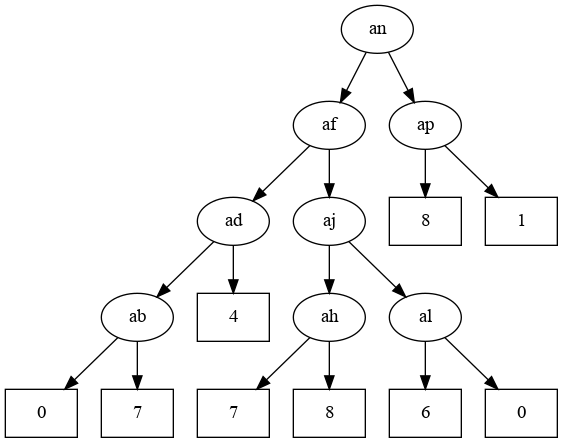

In [29]:
n1 = parser(iter('[[[[4,3],4],4],[7,[[8,4],9]]]'))
n2 = parser(iter('[1,1]'))
n3 = add_nodes(n1, n2)
assert str(n3) == '[[[[0,7],4],[[7,8],[6,0]]],[8,1]]'
display(Image(view_nodes(n3)))

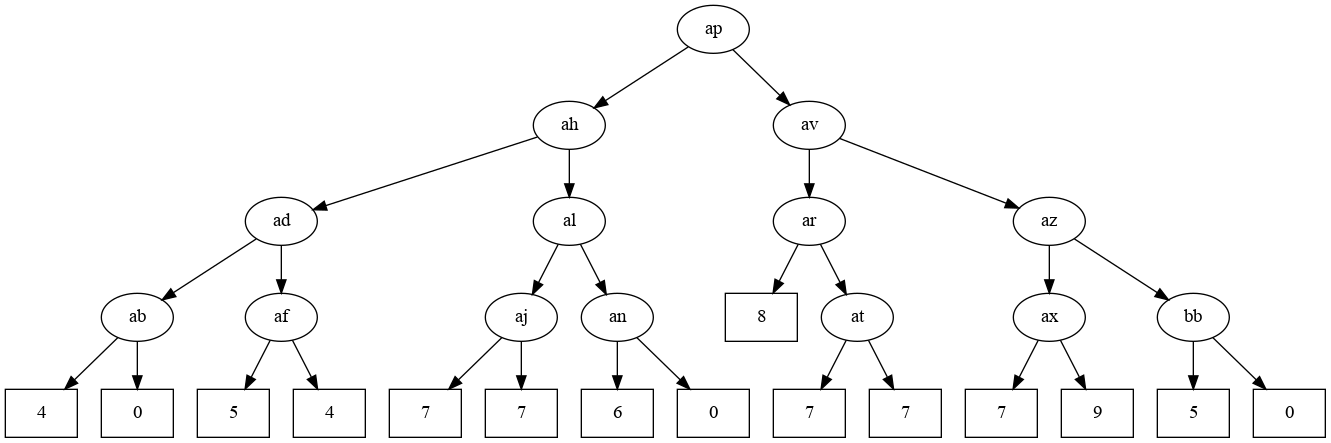

In [30]:
n1 = parser(iter('[[[0,[4,5]],[0,0]],[[[4,5],[2,6]],[9,5]]]'))
n2 = parser(iter('[7,[[[3,7],[4,3]],[[6,3],[8,8]]]]'))
n3 = add_nodes(n1, n2)
display(Image(view_nodes(n3)))
assert str(n3) == '[[[[4,0],[5,4]],[[7,7],[6,0]]],[[8,[7,7]],[[7,9],[5,0]]]]'

In [31]:
from functools import reduce 

def sum_all_lines(lines):
    return reduce(
        add_nodes,
        (parser(iter(line)) for line in lines),
    )

For example, the final sum of this list is `[[[[1,1],[2,2]],[3,3]],[4,4]]`:

```
[1,1]
[2,2]
[3,3]
[4,4]
```

In [32]:
assert str(sum_all_lines([
'[1,1]',
'[2,2]',
'[3,3]',
'[4,4]',
])) == '[[[[1,1],[2,2]],[3,3]],[4,4]]'

The final sum of this list is `[[[[3,0],[5,3]],[4,4]],[5,5]]`:

```
[1,1]
[2,2]
[3,3]
[4,4]
[5,5]
```

In [33]:
sol = sum_all_lines("""[1,1]
[2,2]
[3,3]
[4,4]
[5,5]""".split('\n'))
assert str(sol) == '[[[[3,0],[5,3]],[4,4]],[5,5]]'

The final sum of this list is `[[[[5,0],[7,4]],[5,5]],[6,6]]`:

```
[1,1]
[2,2]
[3,3]
[4,4]
[5,5]
[6,6]
```

In [34]:
sol = sum_all_lines("""[1,1]
[2,2]
[3,3]
[4,4]
[5,5]
[6,6]""".split('\n'))
assert str(sol) == '[[[[5,0],[7,4]],[5,5]],[6,6]]'

```
  [[[0,[4,5]],[0,0]],[[[4,5],[2,6]],[9,5]]]
+ [7,[[[3,7],[4,3]],[[6,3],[8,8]]]]
= [[[[4,0],[5,4]],[[7,7],[6,0]]],[[8,[7,7]],[[7,9],[5,0]]]]
```

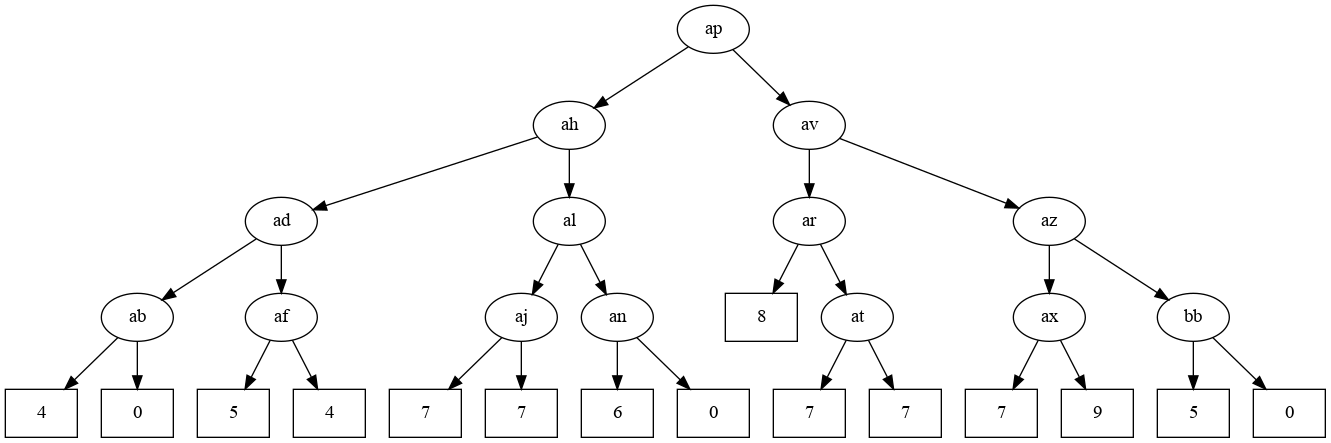

In [35]:
expected = '[[[[4,0],[5,4]],[[7,7],[6,0]]],[[8,[7,7]],[[7,9],[5,0]]]]'
n = sum_all_lines('''[[[0,[4,5]],[0,0]],[[[4,5],[2,6]],[9,5]]]
[7,[[[3,7],[4,3]],[[6,3],[8,8]]]]'''.split('\n'))
assert str(n) == expected
display(Image(view_nodes(n3)))

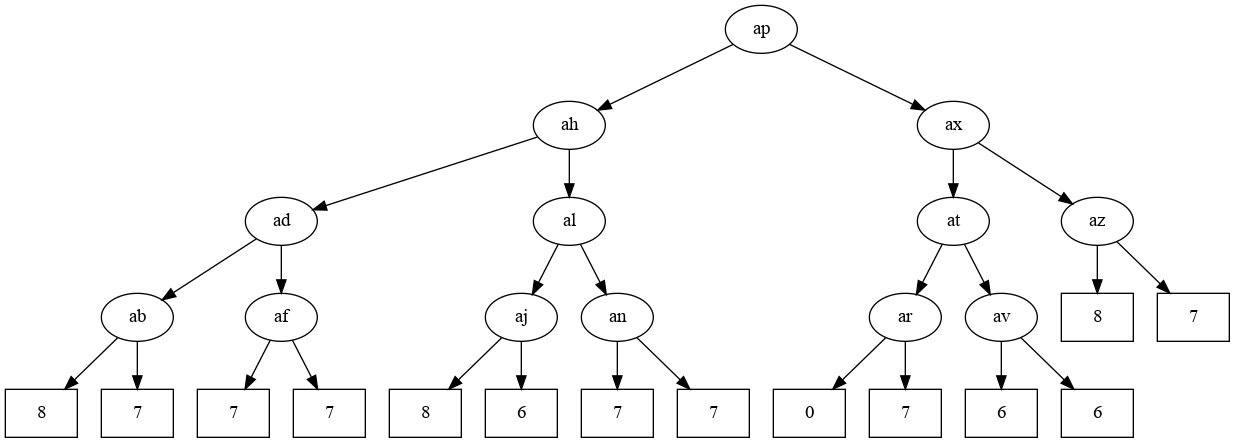

In [36]:
sol = sum_all_lines(load_input("18-sample-2.txt"))
assert str(sol) == '[[[[8,7],[7,7]],[[8,6],[7,7]]],[[[0,7],[6,6]],[8,7]]]'
display(Image(view_nodes(sol)))

To check whether it's the right answer, the snailfish teacher only checks the **magnitude** of the final sum. The magnitude of a pair is 3 times the magnitude of its left element plus 2 times the magnitude of its right element. The magnitude of a regular number is just that number.

In [37]:
def magnitude(node):
    if node.is_terminal():
        return node.value
    else:
        left_value = magnitude(node.left)
        right_value = magnitude(node.right)
        return 3 * left_value + 2 * right_value

For example, the magnitude of `[9,1]` is $3*9 + 2*1 = 29$; the magnitude of `[1,9]` is $3*1 + 2*9 = 21$. Magnitude calculations are recursive: the magnitude of `[[9,1],[1,9]]` is $3*29 + 2*21 = 129$.

In [38]:
assert magnitude(parser(iter('[9,1]'))) == 29
assert magnitude(parser(iter('[1,9]'))) == 21
assert magnitude(parser(iter('[[9,1],[1,9]]'))) == 129


In [39]:
def solution_part_one(filename):
    stream = load_input(filename)
    tree = sum_all_lines(stream)
    return magnitude(tree)

In [40]:
assert solution_part_one('18-sample-4.txt') == 4140

### Solution part one

In [41]:
sol = solution_part_one('18-input.txt')
print(f"Solution part one is: {sol}")

Solution part one is: 4365


## Part two

In [42]:
def solution_part_two(filename):
    lines = list(load_input(filename))
    
    def iter_lines():    
        for n, m in itertools.product(lines, lines):
            tree = add_nodes(parser(iter(n)), parser(iter(m)))
            yield magnitude(tree)
            
    return max(m for m in iter_lines())

In [43]:
assert solution_part_two('18-sample-4.txt') == 3993

In [44]:
sol = solution_part_two('18-input.txt')
print(f"Solution part two is: {sol}")

Solution part two is: 4490
